<a href="https://colab.research.google.com/github/alexauto/r_py_ewd/blob/main/book_neuro_net_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
# indicate that you're running R code
# %%R

# Install if it's your first time to run
# install.packages("class")
# install.packages("data.table")
# install.packages("gmodels")
# install.packages("stringr")
# install.packages("dplyr")
# install.packages("tidyverse")

library(class)
# library(data.table)
library(gmodels)
library(stringr)
library(dplyr)
library(tidyverse)
library(tm)


In [11]:
# # Load R
# %reload_ext rpy2.ipython
# %config IPCompleter.greedy=True
# %config InlineBackend.figure_format = 'retina'
# install.packages("tm")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [12]:
getwd()
# /content/sample_data/wisc_bc_data.csv

[1] "/content"

In [16]:
library(class)
library(gmodels)

wbcd <- read.csv("/content/sample_data/wisc_bc_data.csv", stringsAsFactors = FALSE)

str(wbcd)
wbcd <- wbcd[-1]
table(wbcd$diagnosis)
wbcd$diagnosis<- factor(wbcd$diagnosis, levels = c("B", "M"),
                        labels = c("Benign", "Malignant"))

round(prop.table(table(wbcd$diagnosis)) * 100, digits = 1)
summary(wbcd[c("radius_mean", "area_mean", "smoothness_mean")])


normalize <- function(x) {
  return ((x - min(x)) / (max(x) - min(x)))
}
normalize(c(10, 20, 30, 40, 50))
#
wbcd_n <- as.data.frame(lapply(wbcd[2:31], normalize))
#
# Чтобы подтвердить, что преобразование было применено правильно,
# давайте посмотрим на сводную статистику одной переменной:
summary(wbcd_n$area_mean)

# Как и ожидалось, переменная area_mean,
# которая изначально находилась в диапазоне от 143,5 до 2501,0,
# теперь находится в диапазоне от 0 до 1.

wbcd_train <- wbcd_n[1:469, ]
wbcd_test <- wbcd_n[470:569, ]
#
# Когда мы создавали наши нормализованные обучающие и тестовые наборы данных, мы исключили
# целевую переменную, диагноз. Для обучения модели k-NN нам нужно будет сохранить
# эти метки классов в векторах факторов, разделенных между обучающим и тестовым наборами данных:
wbcd_train_labels <- wbcd[1:469, 1]
wbcd_test_labels <- wbcd[470:569, 1]
# Этот код берет фактор диагноза в первом столбце кадра данных wbcd и
# создает векторы wbcd_train_labels и wbcd_test_labels. Мы будем использовать их
# на следующих этапах обучения и оценки нашего классификатора.


wbcd_test_pred <- knn(train = wbcd_train, test = wbcd_test,
                      cl = wbcd_train_labels, k = 21)
# Функция knn() возвращает вектор-фактор предсказанных меток для каждого из
# примеров в тестовом наборе данных, который мы назначили wbcd_test_pred.

CrossTable(x = wbcd_test_labels, y = wbcd_test_pred,
           prop.chisq=FALSE)
#
# Проценты клеток в таблице указывают долю значений, которые попадают в четыре
# категории. Верхняя левая ячейка указывает на истинно отрицательные результаты. Эти 61 из 100 значений
# являются случаями, когда масса была доброкачественной, и алгоритм k-NN правильно идентифицировал ее
# как таковую. Нижняя правая ячейка указывает на истинно положительные результаты, когда классификатор
# и клинически определенная метка соглашаются, что масса является злокачественной. Всего 37 из
# 100 прогнозов были истинно положительными.
# Ячейки, попадающие на другую диагональ, содержат количество примеров, когда подход k-NN
# не согласуется с истинной меткой. Два примера в нижней левой ячейке
# являются ложноотрицательными результатами; в этом случае предсказанное значение было доброкачественным, но опухоль
# была на самом деле злокачественной. Ошибки в этом направлении могут быть чрезвычайно дорогостоящими, поскольку они
# могут заставить пациента поверить, что у него нет рака, но на самом деле болезнь может
# продолжать распространяться. Верхняя правая ячейка будет содержать ложноположительные результаты, если
# они были. Эти значения возникают, когда модель классифицирует массу как злокачественную,
# но на самом деле она была доброкачественной. Хотя такие ошибки менее опасны, чем ложноотрицательный результат, их также следует избегать, поскольку они могут привести к дополнительной финансовой
# нагрузке на систему здравоохранения или дополнительному стрессу для пациента, поскольку могут потребоваться дополнительные
# тесты или лечение.
# Если бы мы хотели, мы могли бы полностью исключить ложноотрицательные результаты,
# классифицируя каждую массу как злокачественную. Очевидно, что это нереалистичная
# стратегия. Тем не менее, она иллюстрирует тот факт, что прогнозирование включает в себя
# соблюдение баланса между ложноположительным и ложноотрицательным коэффициентами.
# В главе 10 «Оценка эффективности модели» вы узнаете о более
# сложных методах измерения точности прогнозирования, которые
# могут использоваться для определения мест, где можно оптимизировать частоту ошибок
# в зависимости от стоимости каждого типа ошибки.
# Всего 2 из 100, или 2 процента масс, были неправильно классифицированы с помощью подхода k-NN. Хотя точность в 98 процентов кажется впечатляющей для нескольких строк кода R,
# мы можем попробовать еще одну итерацию модели, чтобы посмотреть, сможем ли мы улучшить
# производительность и сократить количество значений, которые были неправильно классифицированы,
# особенно потому, что ошибки были опасными ложноотрицательными.
#
wbcd_z <- as.data.frame(scale(wbcd[-1]))
summary(wbcd_z$area_mean)
# Среднее значение стандартизированной переменной z-оценки всегда должно быть равно нулю, а диапазон
# должен быть достаточно компактным. Z-оценка больше 3 или меньше -3 указывает на
# крайне редкое значение. Учитывая это, преобразование, похоже, сработало.
# Как мы делали ранее, нам нужно разделить данные на обучающие и тестовые наборы, а
# затем классифицировать тестовые экземпляры с помощью функции knn(). Затем мы сравним
# предсказанные метки с фактическими метками с помощью CrossTable():
#
wbcd_train <- wbcd_z[1:469, ]
wbcd_test <- wbcd_z[470:569, ]
wbcd_train_labels <- wbcd[1:469, 1]
wbcd_test_labels <- wbcd[470:569, 1]
#
wbcd_test_pred <- knn(train = wbcd_train, test = wbcd_test,
                      cl = wbcd_train_labels, k = 21)

CrossTable(x = wbcd_test_labels, y = wbcd_test_pred,
           prop.chisq = FALSE)
#
# К сожалению, в следующей таблице результаты нашего нового преобразования показывают
# небольшое снижение точности. В случаях, когда мы правильно классифицировали 98 процентов примеров ранее, на этот раз мы классифицировали только 95 процентов правильно. Что еще хуже, мы не стали лучше классифицировать опасные ложноотрицательные результаты:
#
# Хотя классификатор никогда не был идеальным, подход 1-NN смог избежать
# некоторых ложных отрицательных результатов за счет добавления ложных положительных результатов. Однако важно
# иметь в виду, что было бы неразумно слишком тесно подгонять наш подход к
# нашим тестовым данным; в конце концов, другой набор из 100 записей пациентов, скорее всего, будет несколько
# отличаться от тех, которые использовались для измерения нашей эффективности.
# Если вам нужно быть уверенным, что обучающийся будет обобщать будущие
# данные, вы можете создать несколько наборов из 100 пациентов случайным образом и
# неоднократно повторно тестировать результат. Методы тщательной оценки
# производительности моделей машинного обучения будут обсуждаться
# далее в Главе 10, Оценка эффективности модели.

'data.frame':	569 obs. of  32 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : chr  "M" "M" "M" "M" ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se             : num  0.905 0.734 0.787 1


  B   M 
357 212 


   Benign Malignant 
     62.7      37.3 

  radius_mean       area_mean      smoothness_mean  
 Min.   : 6.981   Min.   : 143.5   Min.   :0.05263  
 1st Qu.:11.700   1st Qu.: 420.3   1st Qu.:0.08637  
 Median :13.370   Median : 551.1   Median :0.09587  
 Mean   :14.127   Mean   : 654.9   Mean   :0.09636  
 3rd Qu.:15.780   3rd Qu.: 782.7   3rd Qu.:0.10530  
 Max.   :28.110   Max.   :2501.0   Max.   :0.16340  

[1] 0.00 0.25 0.50 0.75 1.00

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.1174  0.1729  0.2169  0.2711  1.0000 


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  100 

 
                 | wbcd_test_pred 
wbcd_test_labels |    Benign | Malignant | Row Total | 
-----------------|-----------|-----------|-----------|
          Benign |        77 |         0 |        77 | 
                 |     1.000 |     0.000 |     0.770 | 
                 |     0.975 |     0.000 |           | 
                 |     0.770 |     0.000 |           | 
-----------------|-----------|-----------|-----------|
       Malignant |         2 |        21 |        23 | 
                 |     0.087 |     0.913 |     0.230 | 
                 |     0.025 |     1.000 |           | 
                 |     0.020 |     0.210 |           | 
-----------------|-----------|-----------|-----------|
    Column Total |        79 |        21 |       100 | 
           

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-1.4532 -0.6666 -0.2949  0.0000  0.3632  5.2459 


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|         N / Table Total |
|-------------------------|

 
Total Observations in Table:  100 

 
                 | wbcd_test_pred 
wbcd_test_labels |    Benign | Malignant | Row Total | 
-----------------|-----------|-----------|-----------|
          Benign |        77 |         0 |        77 | 
                 |     1.000 |     0.000 |     0.770 | 
                 |     0.975 |     0.000 |           | 
                 |     0.770 |     0.000 |           | 
-----------------|-----------|-----------|-----------|
       Malignant |         2 |        21 |        23 | 
                 |     0.087 |     0.913 |     0.230 | 
                 |     0.025 |     1.000 |           | 
                 |     0.020 |     0.210 |           | 
-----------------|-----------|-----------|-----------|
    Column Total |        79 |        21 |       100 | 
           

In [1]:
sms_raw <- read.csv("/content/sample_data/sms_spam.csv", stringsAsFactors = FALSE)

In [2]:
str(sms_raw)

'data.frame':	5574 obs. of  2 variables:
 $ type: chr  "ham" "ham" "spam" "ham" ...
 $ text: chr  "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..." "Ok lar... Joking wif u oni..." "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question("| __truncated__ "U dun say so early hor... U c already then say..." ...


In [3]:
# The type element is currently a character vector. Since this is a categorical variable, it
# would be better to convert it into a factor, as shown in the following code:
sms_raw$type <- factor(sms_raw$type)

In [4]:
str(sms_raw$type)

 Factor w/ 2 levels "ham","spam": 1 1 2 1 1 2 1 1 2 2 ...


In [13]:
# install.packages("tm")
library(tm)

Loading required package: NLP



In [14]:
sms_corpus <- VCorpus(VectorSource(sms_raw$text))

In [15]:
print(sms_corpus)

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5574


In [17]:
# Поскольку корпус tm по сути является сложным списком, мы можем использовать операции со списками для выбора
# документов в корпусе. Чтобы получить сводку определенных сообщений, мы можем использовать
# функцию inspect() с операторами списка. Например, следующая команда
# просмотрит сводку первого и второго SMS-сообщений в корпусе:
inspect(sms_corpus[1:2])

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2

[[1]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 111

[[2]]
<<PlainTextDocument>>
Metadata:  7
Content:  chars: 29



In [18]:
as.character(sms_corpus[[1]])

[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

In [19]:
lapply(sms_corpus[1:2], as.character)

$`1`
[1] "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."

$`2`
[1] "Ok lar... Joking wif u oni..."

Как отмечалось ранее, корпус содержит необработанный текст 5559 текстовых сообщений. Чтобы выполнить анализ, нам нужно разделить эти сообщения на отдельные слова.
Но сначала нам нужно очистить текст, чтобы стандартизировать слова, удалив
знаки препинания и другие символы, которые загромождают результат. Например, мы хотели бы, чтобы
строки Hello!, HELLO и hello считались экземплярами одного и того же слова.
Функция tm_map() предоставляет метод для применения преобразования (также известного как отображение) к корпусу tm. Мы будем использовать эту функцию для очистки нашего корпуса с помощью
серии преобразований и сохранения результата в новом объекте corpus_clean.

In [25]:
sms_corpus_clean <- tm_map(sms_corpus,
content_transformer(tolower))

sms_corpus_clean <- tm_map(sms_corpus_clean, removeNumbers)

sms_corpus_clean <- tm_map(sms_corpus_clean,
removeWords, stopwords())

sms_corpus_clean <- tm_map(sms_corpus_clean, removePunctuation)



In [22]:
# replacePunctuation <- function(x) {
#                gsub("[[:punct:]]+", " ", x)
install.packages("SnowballC")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [26]:
library(SnowballC)

In [27]:
sms_corpus_clean <- tm_map(sms_corpus_clean, stemDocument)

In [28]:
sms_corpus_clean <- tm_map(sms_corpus_clean, stripWhitespace)

In [29]:
sms_dtm <- DocumentTermMatrix(sms_corpus_clean)

In [30]:
sms_dtm2 <- DocumentTermMatrix(sms_corpus, control = list(
tolower = TRUE, removeNumbers = TRUE,
stopwords = TRUE,
removePunctuation = TRUE,
stemming = TRUE
))

In [31]:
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test <- sms_dtm[4170:5559, ]

In [32]:
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels <- sms_raw[4170:5559, ]$type

In [35]:
# install.packages("wordcloud")
library(wordcloud)

Loading required package: RColorBrewer



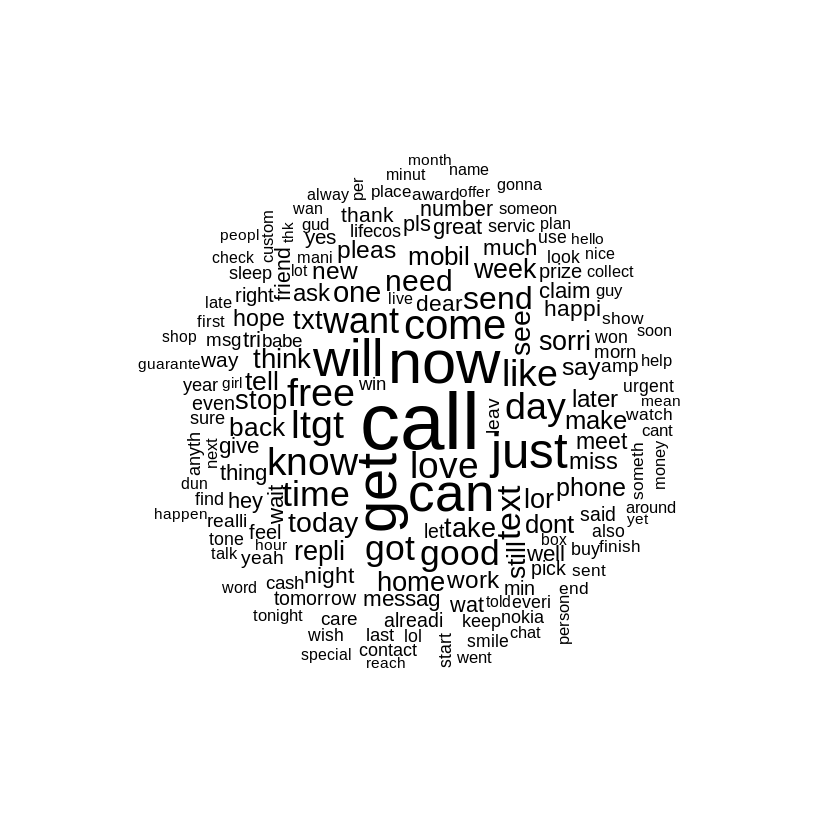

In [36]:
wordcloud(sms_corpus_clean, min.freq = 50, random.order = FALSE)

In [37]:
spam <- subset(sms_raw, type == "spam")
ham <- subset(sms_raw, type == "ham")

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
“transformation drops documents”


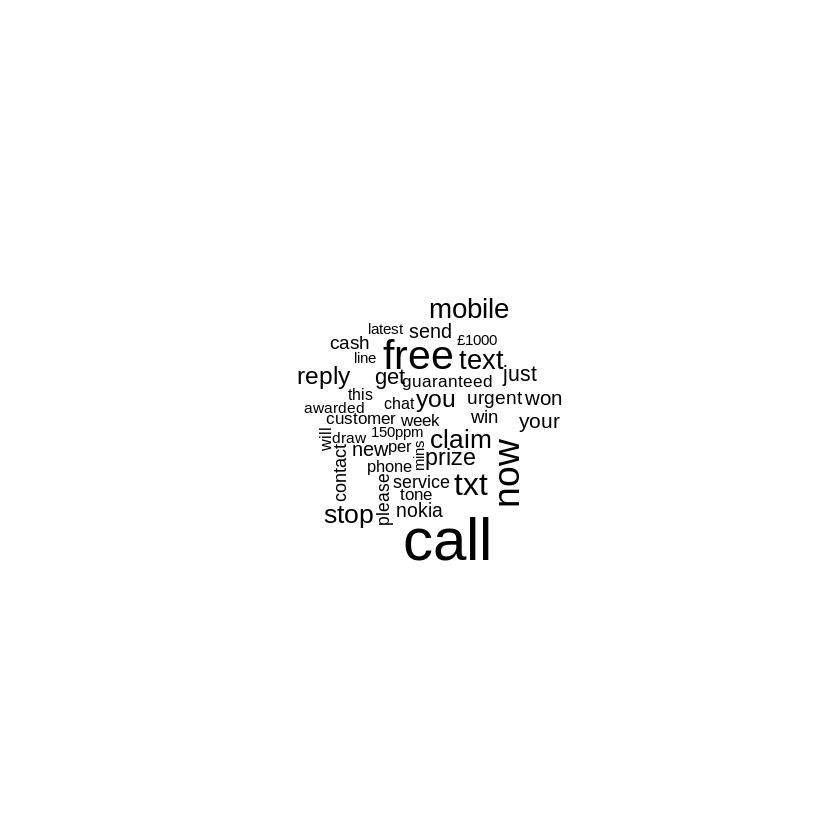

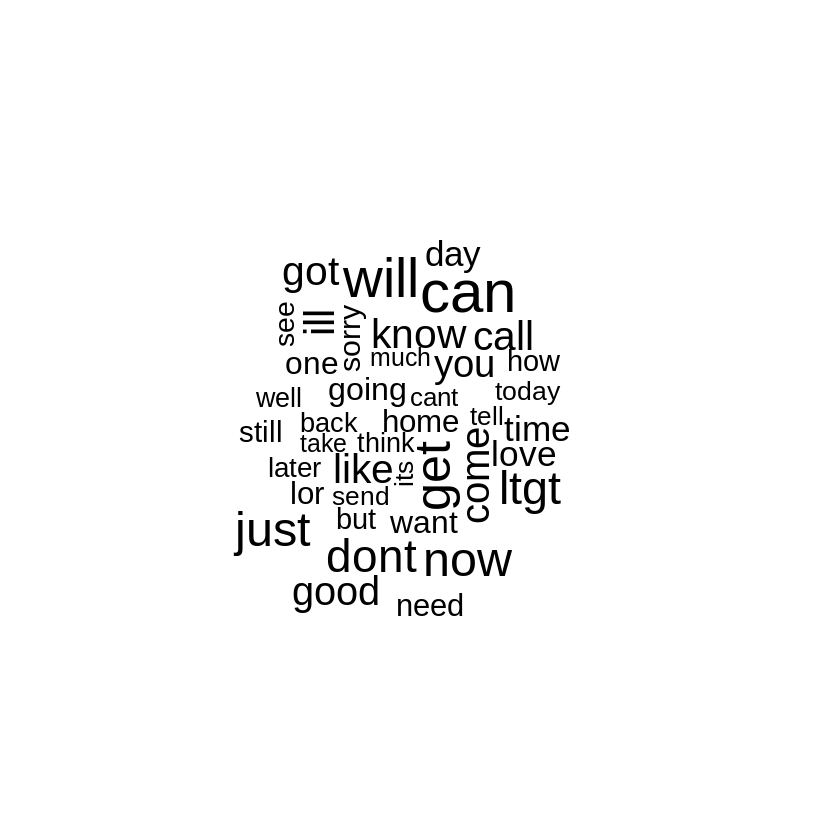

In [38]:
wordcloud(spam$text, max.words = 40, scale = c(3, 0.5))
wordcloud(ham$text, max.words = 40, scale = c(3, 0.5))

Последним шагом в процессе подготовки данных является преобразование разреженной матрицы в
структуру данных, которую можно использовать для обучения наивного байесовского классификатора. В настоящее время разреженная
матрица включает более 6500 признаков; это признак для каждого слова, которое появляется как минимум в одном SMS-сообщении. Маловероятно, что все они полезны для классификации. Чтобы
сократить количество признаков, мы удалим любое слово, которое появляется менее чем в пяти
SMS-сообщениях или менее чем в 0,1 процента записей в обучающих данных.
Для поиска часто встречающихся слов требуется использование функции findFreqTerms() в
пакете tm. Эта функция принимает DTM и возвращает вектор символов, содержащий
слова, которые появляются как минимум указанное количество раз. Например,
следующая команда отобразит слова, которые появляются как минимум пять раз в
матрице sms_dtm_train:

In [39]:
findFreqTerms(sms_dtm_train, 5)

[1] "£wk"           "abiola"        "abl"           "abt"          
   [5] "accept"        "access"        "account"       "across"       
   [9] "activ"         "actual"        "add"           "address"      
  [13] "admir"         "adult"         "advanc"        "aft"          
  [17] "afternoon"     "aftr"          "age"           "ago"          
  [21] "ahead"         "aight"         "aint"          "air"          
  [25] "aiyah"         "alex"          "almost"        "alon"         
  [29] "alreadi"       "alright"       "alrit"         "also"         
  [33] "alway"         "amp"           "angri"         "announc"      
  [37] "anoth"         "answer"        "anybodi"       "anymor"       
  [41] "anyon"         "anyth"         "anytim"        "anyway"       
  [45] "apart"         "app"           "appli"         "appoint"      
  [49] "appreci"       "april"         "ard"           "area"         
  [53] "argument"      "arm"           "around"        "arrang"       
  [57] "arrest"        "arriv"         "asap"          "ask"          
  [61] "askd"          "asleep"        "ass"           "attempt"      
  [65] "auction"       "avail"         "ave"           "avoid"        
  [69] "await"         "award"         "away"          "awesom"       
  [73] "babe"          "babi"          "back"          "bad"          
  [77] "bag"           "bak"           "balanc"        "bank"         
  [81] "bare"          "bath"          "batteri"       "bcoz"         
  [85] "bcum"          "bday"          "beauti"        "becom"        
  [89] "bed"           "bedroom"       "begin"         "believ"       
  [93] "belli"         "best"          "better"        "bid"          
  [97] "big"           "bill"          "bird"          "birthday"     
 [101] "bit"           "black"         "blank"         "bless"        
 [105] "blue"          "bluetooth"     "bodi"          "bold"         
 [109] "bonus"         "boo"           "book"          "bore"         
 [113] "boss"          "bother"        "bout"          "bowl"         
 [117] "box"           "boy"           "boytoy"        "brand"        
 [121] "break"         "breath"        "brilliant"     "bring"        
 [125] "brother"       "bslvyl"        "btnationalr"   "budget"       
 [129] "bugi"          "bus"           "busi"          "buy"          
 [133] "buzz"          "cabin"         "cafe"          "cal"          
 [137] "call"          "caller"        "callertun"     "camcord"      
 [141] "came"          "camera"        "can"           "cancel"       
 [145] "cant"          "car"           "card"          "care"         
 [149] "carlo"         "case"          "cash"          "cashbal"      
 [153] "catch"         "caus"          "chanc"         "chang"        
 [157] "charact"       "charg"         "chariti"       "chat"         
 [161] "cheap"         "check"         "cheer"         "chennai"      
 [165] "chikku"        "childish"      "children"      "chines"       
 [169] "choic"         "choos"         "christma"      "cine"         
 [173] "cinema"        "claim"         "class"         "clean"        
 [177] "clear"         "click"         "clock"         "close"        
 [181] "club"          "code"          "coffe"         "coin"         
 [185] "cold"          "colleagu"      "collect"       "colleg"       
 [189] "colour"        "come"          "comin"         "comp"         
 [193] "compani"       "competit"      "complet"       "complimentari"
 [197] "comput"        "concentr"      "condit"        "confid"       
 [201] "confirm"       "congrat"       "congratul"     "connect"      
 [205] "contact"       "content"       "convey"        "cook"         
 [209] "cool"          "copi"          "correct"       "cos"          
 [213] "cost"          "countri"       "coupl"         "cours"        
 [217] "cover"         "coz"           "crave"         "crazi"        
 [221] "credit"        "cri"           "croydon"       "cuddl"        
 [225] "cum"           "cup

In [40]:
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)

In [41]:
str(sms_freq_words)

 chr [1:1157] "£wk" "abiola" "abl" "abt" "accept" "access" "account" ...


In [42]:
sms_dtm_freq_train<- sms_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- sms_dtm_test[ , sms_freq_words]

In [44]:
# Наборы обучающих и тестовых данных теперь включают 1136 признаков, которые соответствуют
# словам, встречающимся как минимум в пяти сообщениях.
# Наивный байесовский классификатор обычно обучается на данных с категориальными признаками.
# Это создает проблему, поскольку ячейки в разреженной матрице являются числовыми и измеряют
# количество раз, когда слово появляется в сообщении. Нам нужно изменить это на
# категориальную переменную, которая просто указывает «да» или «нет» в зависимости от того, появляется ли слово вообще.
# Ниже определяется функция convert_counts() для преобразования счетчиков в
# строки «Да/Нет»:
convert_counts <- function(x) {
x <- ifelse(x > 0, "Да", "Нет")
}

In [45]:
# Теперь нам нужно применить convert_counts() к каждому из столбцов в нашей разреженной матрице. Вы можете угадать функцию R, которая делает именно это. Функция
# просто называется apply() и используется так же, как lapply(), использовавшаяся ранее.
# Функция apply() позволяет использовать функцию для каждой из строк или столбцов
# в матрице. Она использует параметр MARGIN для указания строк или столбцов. Здесь
# мы будем использовать MARGIN = 2, так как нас интересуют столбцы (MARGIN = 1 используется
# для строк). Команды для преобразования обучающей и тестовой матриц следующие:
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2,convert_counts)

sms_test <- apply(sms_dtm_freq_test, MARGIN = 2,convert_counts)


In [47]:
# install.packages("e1071")
library(e1071)

In [48]:
sms_classifier <- naiveBayes(sms_train, sms_train_labels)

In [49]:
sms_test_pred <- predict(sms_classifier, sms_test)

In [51]:
install.packages("gmodels")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gtools’, ‘gdata’




In [52]:
library(gmodels)
CrossTable(sms_test_pred, sms_test_labels,
prop.chisq = FALSE, prop.t = FALSE,
dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Row Total |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1200 |        20 |      1220 | 
             |     0.984 |     0.016 |     0.878 | 
             |     0.993 |     0.110 |           | 
-------------|-----------|-----------|-----------|
        spam |         9 |       161 |       170 | 
             |     0.053 |     0.947 |     0.122 | 
             |     0.007 |     0.890 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1209 |       181 |      1390 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


In [53]:
sms_classifier2 <- naiveBayes(sms_train, sms_train_labels,
laplace = 1)

In [54]:
sms_test_pred2 <- predict(sms_classifier2, sms_test)

In [ ]:
CrossTable(sms_test_pred2, sms_test_labels,
prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
dnn = c('predicted', 'actual'))

In [55]:
CrossTable(sms_test_pred2, sms_test_labels,
prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1182 |        10 |      1192 | 
             |     0.978 |     0.055 |           | 
-------------|-----------|-----------|-----------|
        spam |        27 |       171 |       198 | 
             |     0.022 |     0.945 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1209 |       181 |      1390 | 
             |     0.870 |     0.130 |           | 
-------------|-----------|-----------|-----------|

 


Добавление оценщика Лапласа сократило количество ложных срабатываний (нежелательных сообщений, ошибочно классифицированных как спам) с шести до пяти, а количество ложных срабатываний
с ​​30 до 28. Хотя это кажется небольшим изменением, оно существенно, учитывая,
что точность модели уже была весьма впечатляющей.

In [56]:
install.packages("ROCR")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘caTools’, ‘gplots’




Модель
Задача обучения
Название метода
Параметры
k-ближайшие соседи
Классификация
knn
k
Наивный байесовский
Классификация
nb
fL, usekernel
Деревья решений
Классификация
C5.0
модель, испытания, просеивание
OneR Rule Learner
Классификация
OneR
Нет
RIPPER Rule Learner
Классификация
JRip
NumOpt
Линейная регрессия
Регрессия
lm
Нет
Деревья регрессии
Регрессия
rpart
cp
Деревья моделей
Регрессия
M5
обрезанный, сглаженный,
правила
Нейронные сети
Двойное использование
nnet
размер, распад
Машины опорных векторов
(Линейное ядро)
Двойное использование
svmLinear
C
Машины опорных векторов
(Радиальное базисное ядро)
Двойное использование
svmRadial
C, sigma
Случайные леса
Двойное использование
rf
mtry


In [57]:
library(ROCR)
pred <- prediction(predictions = sms_results$prob_spam,
labels = sms_results$actual_type)

ERROR: Error: object 'sms_results' not found


In [59]:
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [61]:
# sms_raw <- read.csv("/content/sample_data/sms_spam.csv", stringsAsFactors = FALSE)
credit <- read.csv("/content/sample_data/credit.csv", stringsAsFactors = FALSE)

In [62]:
library(randomForest)
set.seed(300)
rf <- randomForest(default ~ ., data = credit)

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


In [63]:
rf


Call:
 randomForest(formula = default ~ ., data = credit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 6

          Mean of squared residuals: 0.1626498
                    % Var explained: 22.55

В выходных данных указано, что случайный лес включал 500 деревьев и пробовал четыре переменные при каждом разбиении, как мы и ожидали. На первый взгляд, вы можете быть встревожены кажущейся
плохой производительностью согласно матрице путаницы — уровень ошибок 23,8 процента
намного хуже, чем ошибка повторной замены любого из других ансамблевых методов до сих пор. Однако эта матрица путаницы не показывает ошибку повторной замены. Вместо этого она
отражает уровень ошибок вне мешка (указанный в выходных данных как оценка OOB уровня ошибок), который, в отличие от ошибки повторной замены, является несмещенной оценкой ошибки тестового набора.
Это означает, что это должна быть довольно разумная оценка будущей производительности.
Оценка вне мешка вычисляется во время построения случайного леса.
По сути, любой пример, не выбранный для выборки бутстрапа одного дерева,
можно использовать для проверки производительности модели на невидимых данных. В конце построения леса
прогнозы для каждого примера каждый раз, когда он был выдвинут, подсчитываются, и проводится голосование, чтобы определить окончательный прогноз для примера. Общая частота ошибок таких
предсказаний становится частотой ошибок вне мешка.

In [64]:
install.packages("caret")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘prodlim’, ‘iterators’, ‘clock’, ‘gower’, ‘hardhat’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘plyr’, ‘pROC’, ‘recipes’, ‘reshape2’




Как упоминалось ранее, функция randomForest() поддерживается функцией caret,
что позволяет нам оптимизировать модель, одновременно вычисляя
показатели производительности за пределами частоты ошибок out-of-bag. Чтобы было интереснее,
давайте сравним автоматически настроенный случайный лес с лучшей автоматически настроенной усиленной моделью C5.0,
которую мы разработали. Мы будем рассматривать этот эксперимент так, как будто мы надеемся определить
модель-кандидата для отправки на конкурс машинного обучения.
Сначала мы должны загрузить функцию caret и задать параметры управления обучением. Для наиболее точного
сравнения производительности модели мы будем использовать повторную 10-кратную перекрестную проверку или
10-кратный CV, повторенный 10 раз. Это означает, что модели потребуют гораздо больше времени для построения и будут более интенсивными для оценки, но поскольку это наше последнее сравнение, мы должны быть уверены, что делаем правильный
выбор; победитель этого поединка будет нашим единственным участником в конкурсе машинного обучения.

In [65]:
library(caret)
ctrl <- trainControl(method = "repeatedcv",
number = 10, repeats = 10)

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin


The following object is masked from ‘package:NLP’:

    annotate


Loading required package: lattice



In [66]:
grid_rf <- expand.grid(.mtry = c(2, 4, 8, 16))

In [73]:
# library(caret)
# ctrl <- trainControl(method = "repeatedcv",
# number = 10, repeats = 10)
# # Next, we'll set up the tuning grid for the random forest. The only tuning parameter
# # for this model is mtry, which defines how many features are randomly selected at
# # each split. By default, we know that the random forest will use sqrt(16), or four
# # features per tree. To be thorough, we'll also test values half of that, twice that, as well
# # as the full set of 16 features. Thus, we need to create a grid with values of 2, 4, 8, and
# # 16 as follows:
# grid_rf <- expand.grid(.mtry = c(2, 4, 8, 16))
# # A random forest that considers the full set of features at each split is
# # essentially the same as a bagged decision tree model.
# # We can supply the resulting grid to the train() function with the ctrl object as
# # follows. We'll use the kappa metric to select the best model:
# set.seed(300)
# m_rf <- train(default ~ ., data = credit, method = "rf",
# metric = "Kappa", trControl = ctrl,
# tuneGrid = grid_rf)

Выполнение предыдущей команды может занять некоторое время, поскольку ей предстоит проделать довольно много работы! Когда она завершится, мы сравним ее с расширенным деревом, использующим 10, 20, 30 и 40 итераций:

In [72]:
# m_rf <- train(default ~ ., data = credit, method = "rf",
# metric = "Kappa", trControl = ctrl,
# tuneGrid = grid_rf)

In [71]:
# grid_c50 <- expand.grid(.model = "tree",
# .trials = c(10, 20, 30, 40),
# .winnow = "FALSE")
# set.seed(300)
# m_c50 <- train(default ~ ., data = credit, method = "C5.0",
# metric = "Kappa", trControl = ctrl,
# tuneGrid = grid_c50)
# # When the C5.0 decision tree finally completes, we can compare the two approaches
# # side-by-side. For the random forest model, the results are:
# m_rf